# AgriSpectra


## Introduction

Here is the task description and baseline models and experiments: https://www.kaggle.com/code/anastasiagapeeva/agrispectraresearch#AgriSpectra

I'm using Eyes on the ground dataset which described in detail in previous part of the work available via link above.    
I've not obtain good quality on whole classes for crop name and damage, so one of my baseline assumptions is left only maize from crops, so, now I would not predict any crop name, and only 3 types of damages: G (Good (growth)), WD (Weed) and DR (Drought).  Growth Stages stay same as in original dataset: F (Flowering), M (Maturity), S (Sowing), V (Vegetative). Extent also stay the same, from 0 to 100.    

At this step of work I will try to use following techniques to improve models quality:
- special data augmentations for underrepresented classes;
- WeightedRandomSampler;
- more complex model architecture;
- weighted CrossEntropyLoss;
- AdamW optimizer;
- for the early stopping mechanism, monitor not the discrete metric (F1), but the validation loss;
- selection of optimizer and scheduler parameters in a cycle for a model with the best architecture.

It would be appropriate to apply different improvement strategies gradually and evaluate the contribution of each, but in the context of a very tight deadline, I will group these methods as follows:
1. Step 1: choose best model from previously trained, then use:
- special data augmentations for underrepresented classes;
- AdamW optimizer;
- for the early stopping mechanism, monitor not the discrete metric (F1), but the validation loss;
2. Step 2: all above with more complex model architecture;
3. Step 3: use WeightedRandomSampler;
4. Step 4: use weighted CrossEntropyLoss;   
5. Step 5: selection of optimizer and scheduler parameters in a cycle for a model with the best architecture;   
   
For the Step 1 let's choose best model from two baseline models, because all experiments led to overfitting.


## Imports

In [1]:
!pip install python-dotenv

All necessary imports are below:

In [2]:
import os
import time
import wandb
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as T
import torch.nn as nn
import torch.optim as optim
from multiprocessing import cpu_count
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision.models import resnet18, efficientnet_b0, ResNet18_Weights, EfficientNet_B0_Weights
from dotenv import load_dotenv
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from PIL import Image
from glob import glob
from typing import List, Dict, Any, Optional
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.utils.class_weight import compute_class_weight
from collections import defaultdict, Counter
from PIL import Image, ImageStat
from tqdm import tqdm
from IPython.display import clear_output

In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed May 28 20:38:58 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   68C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Variables and wandb adjusting

Track experiments in wandb:

In [4]:
load_dotenv('/content/drive/MyDrive/AgriSpectra/.env')

wandb_key = os.getenv("WANDB_API_KEY")
wandb.login(key=wandb_key)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: anastasiia-gapeeva (a-gapeeva) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [5]:
def init_wandb_run(
    model_name: str,
    label_maps: dict,
    image_size=(256, 256),
    num_epochs=10,
    learning_rate=1e-4,
    group="effb0_vs_rn18",
    optimizer='AdamW',
    loss='CrossEntropy',
    tags=['improved']
):
    config = {
        "architecture": model_name,
        "image_size": image_size,
        "epochs": num_epochs,
        "learning_rate": learning_rate,
        "optimizer": optimizer,
        "loss": loss,
        "labels": list(label_maps.keys()),
        "num_classes": {k: len(v) for k, v in label_maps.items()}
    }

    wandb.init(
        project="eotg-multilabel",
        name=f"{model_name}_{wandb.util.generate_id()[:4]}",  # run's name
        config=config,
        group=group,
        tags=tags
    )

For the better augmentations quality, let's see where the models most often make mistakes, what are the most common errors.   
We will use checkpoints from previous experiments.

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 32
num_workers = 2

# Models paths
model_paths = {
    'resnet18_bsl': '/content/drive/MyDrive/AgriSpectra/nn_weights/best_model_rn_new.pth',
    'effb0_bsl':    '/content/drive/MyDrive/AgriSpectra/nn_weights/best_model_effb0_new.pth'
}

# Dataset paths
train_csv  = '/content/drive/MyDrive/AgriSpectra/EotG_Dataset/train_new.csv'
valid_csv  = '/content/drive/MyDrive/AgriSpectra/EotG_Dataset/valid_new.csv'
test_csv   = '/content/drive/MyDrive/AgriSpectra/EotG_Dataset/test_new.csv'
image_dir  = '/content/drive/MyDrive/AgriSpectra/EotG_Dataset/images/'

image_size=(256, 256)
# Previously evaluated, refer to Kaggle notebook via link above for details
mean=(0.4536, 0.4510, 0.3253)
std=(0.2462, 0.2511, 0.2887)

# Define image transform
transform = T.Compose([
        T.Resize(image_size),
        T.ToTensor(),
        T.Normalize(mean=mean, std=std)
    ])

## Dataset class definition

In [49]:
# Dataset class definision
class MultiHeadEotGDataset(Dataset):
    def __init__(self, csv_file, image_dir, transform=None, label_maps=None):
        self.df = pd.read_csv(csv_file)
        self.image_dir = image_dir
        self.transform = transform

        # Only 3 labels
        self.label_cols = ['growth_stage', 'damage', 'extent']

        # If label_maps is not passed, build it (only for train)
        if label_maps is None:
            self.label_maps = {
                col: {val: i for i, val in enumerate(sorted(self.df[col].unique()))}
                for col in self.label_cols
            }
        else:
            self.label_maps = label_maps

        # Reverse mappings: int → string
        self.inverse_label_maps = {
            col: {i: val for val, i in self.label_maps[col].items()}
            for col in self.label_cols
        }

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.image_dir, row['filename'])
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        labels = {
            col: torch.tensor(self.label_maps[col][row[col]], dtype=torch.long)
            for col in self.label_cols
        }

        return image, labels

## ResNet18 based model class definition

In [8]:
# Baseline ResNet18 based model
class MultiHeadClassifierRN18(nn.Module):
    def __init__(self, num_classes_dict):
        super().__init__()
        base_model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1) # pre-trained model weights on the ImageNet-1K dataset
        self.backbone = nn.Sequential(*list(base_model.children())[:-1])  # remove FC

        self.flatten = nn.Flatten()

        self.heads = nn.ModuleDict({
            name: nn.Linear(base_model.fc.in_features, num_classes)
            for name, num_classes in num_classes_dict.items()
        })

    def forward(self, x):
        x = self.backbone(x)
        x = self.flatten(x)

        outputs = {name: head(x) for name, head in self.heads.items()}
        return outputs  # returns dict: {crop_name: logits, growth_stage: logits, ...}

## Efficient-B0 based model class definition

In [9]:
# Baseline EfficientNet-B0 based model
class MultiHeadClassifierEffB0(nn.Module):
    def __init__(self, num_classes_dict):
        super().__init__()
        base_model = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)

        # Delete classification head and replace it with our heads
        self.backbone = base_model.features
        self.pool = base_model.avgpool  # AdaptiveAvgPool2d(output_size=1)
        self.flatten = nn.Flatten()

        in_features = base_model.classifier[1].in_features  # usually 1280

        self.heads = nn.ModuleDict({
            name: nn.Linear(in_features, num_classes)
            for name, num_classes in num_classes_dict.items()
        })

    def forward(self, x):
        x = self.backbone(x)
        x = self.pool(x)
        x = self.flatten(x)

        outputs = {name: head(x) for name, head in self.heads.items()}
        return outputs  # dict: {crop_name: logits, ...}

## Models performance checking

In [10]:
# Initialize train dataset
train_ds = MultiHeadEotGDataset(
    csv_file=train_csv,
    image_dir=image_dir,
    transform=transform
)

label_maps = train_ds.label_maps
inverse_label_maps = train_ds.inverse_label_maps
label_cols = train_ds.label_cols

In [11]:
# Initialize test dataset with same mapping
test_ds = MultiHeadEotGDataset(
    csv_file=test_csv,
    image_dir=image_dir,
    transform=transform,
    label_maps=label_maps
)

In [12]:
test_ds[0]

(tensor([[[ 1.0884,  1.1043,  1.1203,  ...,  0.8654,  0.7858,  0.6424],
          [ 1.0884,  1.1043,  1.1362,  ...,  0.4991,  0.4672,  0.5946],
          [ 1.1203,  1.1362,  1.1521,  ...,  0.3239,  0.2920,  0.4354],
          ...,
          [-0.9982, -0.7911, -0.8071,  ..., -0.7752, -0.7752, -0.6637],
          [-1.0141, -0.8071, -0.7433,  ...,  0.2124, -0.5363, -0.8708],
          [-0.9504, -0.9186, -0.8230,  ...,  0.9132,  1.0247,  0.0371]],
 
         [[ 1.2337,  1.2493,  1.2649,  ...,  0.8277,  0.7652,  0.6402],
          [ 1.2493,  1.2493,  1.2806,  ...,  0.4528,  0.4372,  0.5622],
          [ 1.2806,  1.2806,  1.2962,  ...,  0.2654,  0.2342,  0.3904],
          ...,
          [-1.4213, -1.2182, -1.2495,  ..., -1.5150, -1.4994, -1.4057],
          [-1.4369, -1.2495, -1.2182,  ..., -0.5311, -1.2339, -1.5775],
          [-1.3744, -1.3588, -1.3120,  ...,  0.1405,  0.2498, -0.7185]],
 
         [[ 2.1740,  2.2012,  2.2555,  ...,  0.3538,  0.2452,  0.0686],
          [ 2.1740,  2.2148,

In [13]:
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [14]:
num_classes = {col: len(map_) for col, map_ in train_ds.label_maps.items()}
num_classes

{'growth_stage': 4, 'damage': 3, 'extent': 11}

In [15]:
# Error analysis function for one head
def analyze_head(all_preds, all_labels, classes, head_name, model_name):
    n_classes = len(classes)
    labels_range = list(range(n_classes))

    acc = accuracy_score(all_labels, all_preds)
    f1_macro = f1_score(all_labels, all_preds, labels=labels_range, average='macro', zero_division=0)
    print(f"{model_name} / {head_name} — Accuracy: {acc:.4f}, Macro-F1: {f1_macro:.4f}")
    print("-" * 60)

    class_labels = [str(c) for c in classes]

    cm = confusion_matrix(all_labels, all_preds, labels=labels_range)
    disp = ConfusionMatrixDisplay(cm, display_labels=class_labels)
    fig, ax = plt.subplots(figsize=(6,6))
    disp.plot(ax=ax, xticks_rotation=45)
    ax.set_title(f"{model_name} — {head_name}")
    plt.show()

    report = classification_report(
        all_labels,
        all_preds,
        labels=labels_range,
        target_names=class_labels,
        zero_division=0
    )
    print(f"Classification Report — {model_name} / {head_name}\n")
    print(report)
    print("―" * 80)



===== Evaluating resnet18_bsl =====



Test: 100%|██████████| 93/93 [00:35<00:00,  2.62it/s]


resnet18_bsl — Overall Accuracy (all heads): 0.6641, Overall Macro-F1 (all heads): 0.4046
--------------------------------------------------------------------------------
resnet18_bsl / growth_stage — Accuracy: 0.7893, Macro-F1: 0.7804
------------------------------------------------------------


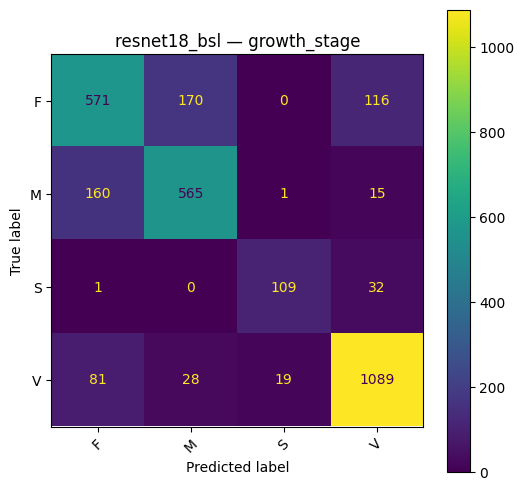

Classification Report — resnet18_bsl / growth_stage

              precision    recall  f1-score   support

           F       0.70      0.67      0.68       857
           M       0.74      0.76      0.75       741
           S       0.84      0.77      0.80       142
           V       0.87      0.89      0.88      1217

    accuracy                           0.79      2957
   macro avg       0.79      0.77      0.78      2957
weighted avg       0.79      0.79      0.79      2957

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
resnet18_bsl / damage — Accuracy: 0.7217, Macro-F1: 0.7269
------------------------------------------------------------


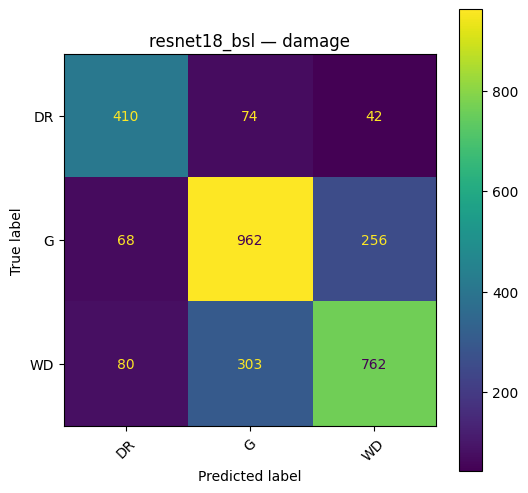

Classification Report — resnet18_bsl / damage

              precision    recall  f1-score   support

          DR       0.73      0.78      0.76       526
           G       0.72      0.75      0.73      1286
          WD       0.72      0.67      0.69      1145

    accuracy                           0.72      2957
   macro avg       0.72      0.73      0.73      2957
weighted avg       0.72      0.72      0.72      2957

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
resnet18_bsl / extent — Accuracy: 0.4812, Macro-F1: 0.2557
------------------------------------------------------------


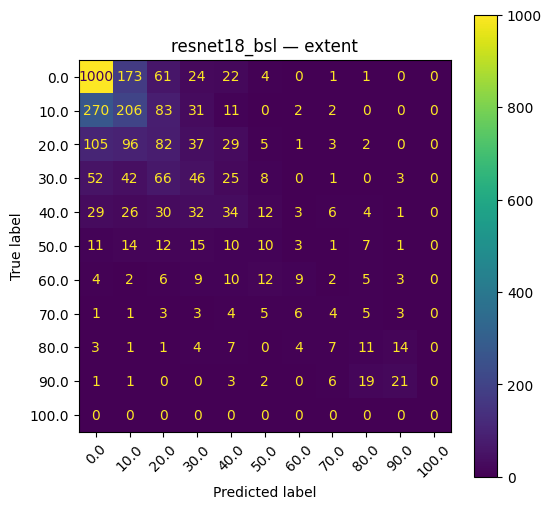

Classification Report — resnet18_bsl / extent

              precision    recall  f1-score   support

         0.0       0.68      0.78      0.72      1286
        10.0       0.37      0.34      0.35       605
        20.0       0.24      0.23      0.23       360
        30.0       0.23      0.19      0.21       243
        40.0       0.22      0.19      0.20       177
        50.0       0.17      0.12      0.14        84
        60.0       0.32      0.15      0.20        62
        70.0       0.12      0.11      0.12        35
        80.0       0.20      0.21      0.21        52
        90.0       0.46      0.40      0.42        53
       100.0       0.00      0.00      0.00         0

    accuracy                           0.48      2957
   macro avg       0.27      0.25      0.26      2957
weighted avg       0.46      0.48      0.47      2957

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


===== Evaluating effb0_bsl =====



Test: 100%|██████████| 93/93 [00:23<00:00,  3.98it/s]


effb0_bsl — Overall Accuracy (all heads): 0.6730, Overall Macro-F1 (all heads): 0.4266
--------------------------------------------------------------------------------
effb0_bsl / growth_stage — Accuracy: 0.8099, Macro-F1: 0.8002
------------------------------------------------------------


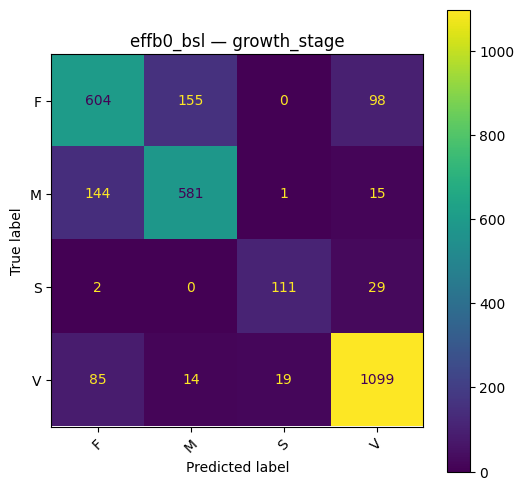

Classification Report — effb0_bsl / growth_stage

              precision    recall  f1-score   support

           F       0.72      0.70      0.71       857
           M       0.77      0.78      0.78       741
           S       0.85      0.78      0.81       142
           V       0.89      0.90      0.89      1217

    accuracy                           0.81      2957
   macro avg       0.81      0.79      0.80      2957
weighted avg       0.81      0.81      0.81      2957

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
effb0_bsl / damage — Accuracy: 0.7261, Macro-F1: 0.7320
------------------------------------------------------------


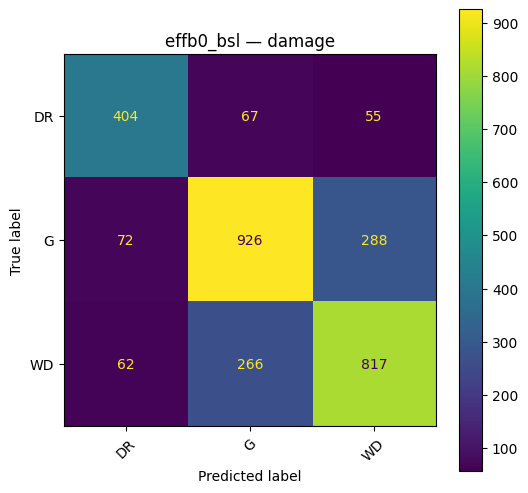

Classification Report — effb0_bsl / damage

              precision    recall  f1-score   support

          DR       0.75      0.77      0.76       526
           G       0.74      0.72      0.73      1286
          WD       0.70      0.71      0.71      1145

    accuracy                           0.73      2957
   macro avg       0.73      0.73      0.73      2957
weighted avg       0.73      0.73      0.73      2957

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
effb0_bsl / extent — Accuracy: 0.4829, Macro-F1: 0.2782
------------------------------------------------------------


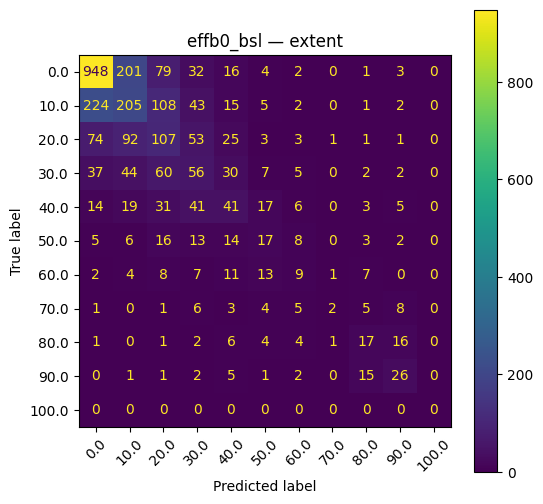

Classification Report — effb0_bsl / extent

              precision    recall  f1-score   support

         0.0       0.73      0.74      0.73      1286
        10.0       0.36      0.34      0.35       605
        20.0       0.26      0.30      0.28       360
        30.0       0.22      0.23      0.22       243
        40.0       0.25      0.23      0.24       177
        50.0       0.23      0.20      0.21        84
        60.0       0.20      0.15      0.17        62
        70.0       0.40      0.06      0.10        35
        80.0       0.31      0.33      0.32        52
        90.0       0.40      0.49      0.44        53
       100.0       0.00      0.00      0.00         0

    accuracy                           0.48      2957
   macro avg       0.30      0.28      0.28      2957
weighted avg       0.48      0.48      0.48      2957

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


In [16]:
# Basic cycle for all models
for model_name, ckpt_path in model_paths.items():
    print(f"\n\n===== Evaluating {model_name} =====\n")
    # Selecting a model class
    if 'resnet18' in model_name:
        model = MultiHeadClassifierRN18(num_classes)
    else:
        model = MultiHeadClassifierEffB0(num_classes)
    # Load weights and translate into eval
    model.load_state_dict(torch.load(ckpt_path, map_location=device))
    model.to(device).eval()

    # Collection of predictions and true marks
    all_preds = {col: [] for col in label_cols}
    all_labels = {col: [] for col in label_cols}
    with torch.no_grad():
        for imgs, labels in tqdm(test_loader, desc='Test'):
            imgs = imgs.to(device)
            outputs = model(imgs)  # dict: {col: logits}
            for col in label_cols:
                preds = outputs[col].argmax(dim=1).cpu().tolist()
                trues = labels[col].cpu().tolist()
                all_preds[col].extend(preds)
                all_labels[col].extend(trues)

    # Overal performance
    flat_preds  = sum(all_preds.values(), [])
    flat_labels = sum(all_labels.values(), [])
    overall_acc    = accuracy_score(flat_labels, flat_preds)
    overall_f1     = f1_score(flat_labels, flat_preds, average='macro', zero_division=0)
    print(f"{model_name} — Overall Accuracy (all heads): {overall_acc:.4f}, "
          f"Overall Macro-F1 (all heads): {overall_f1:.4f}")
    print("-" * 80)

    # Analysis for each label
    for col in label_cols:
        classes = [inverse_label_maps[col][i] for i in range(len(label_maps[col]))]
        analyze_head(all_preds[col], all_labels[col], classes, col, model_name)

Since one of benchmarks for project is latency less than 5, we will test the latency on the CPU and GPU for these two models.



In [47]:
# In addition, check mean inference time for both models
DEVICE = torch.device('cpu')
torch.set_num_threads(cpu_count())

# Check and print where we'll run inference
print(f"torch.cuda.is_available(): {torch.cuda.is_available()}")
print(f"Inference will run on device: {DEVICE}\n")

def load_model(model_class, checkpoint_path, num_classes_dict):
    """
    Load a model onto DEVICE (CPU), set it to eval mode.
    """
    model = model_class(num_classes_dict)
    # map_location=DEVICE ensures weights go to CPU
    model.load_state_dict(torch.load(checkpoint_path, map_location=DEVICE))
    model.to(DEVICE)
    model.eval()
    return model

# Create a dummy input tensor on DEVICE
dummy_input = torch.randn(1, 3, 224, 224, device=DEVICE)
print(f"Dummy input device: {dummy_input.device}\n")

# Benchmark each model in model_paths on CPU
for model_name, ckpt_path in model_paths.items():
    print(f"--- {model_name} ---")
    # Select the correct class based on name
    ModelClass = MultiHeadClassifierRN18 if 'resnet18' in model_name else MultiHeadClassifierEffB0

    # Load model onto DEVICE
    model = load_model(ModelClass, ckpt_path, num_classes)
    # Verify model parameters device
    param_device = next(model.parameters()).device
    print(f"Model parameters device: {param_device}")

    # Warm-up runs (keeps measurement consistent)
    for _ in range(10):
        _ = model(dummy_input)

    # Measure average inference time
    repetitions = 100
    start_time = time.perf_counter()
    for _ in range(repetitions):
        _ = model(dummy_input)
    avg_ms = (time.perf_counter() - start_time) / repetitions * 1000

    print(f'{model_name}: {avg_ms:.2f} ms per inference on {DEVICE}\n')

torch.cuda.is_available(): True
Inference will run on device: cpu

Dummy input device: cpu

--- resnet18_bsl ---
Model parameters device: cpu
resnet18_bsl: 92.05 ms per inference on cpu

--- effb0_bsl ---
Model parameters device: cpu
effb0_bsl: 53.70 ms per inference on cpu



In [48]:
# Now let's check on GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Inference will run on device: {device}")

dummy_input = torch.randn(1, 3, 224, 224, device=device)
print(f"Dummy input device: {dummy_input.device}\n")

for model_name, ckpt_path in model_paths.items():
    print(f"--- {model_name} ---")

    ModelClass = MultiHeadClassifierRN18 if 'resnet18' in model_name else MultiHeadClassifierEffB0

    model = ModelClass(num_classes)
    model.load_state_dict(torch.load(ckpt_path, map_location=device))
    model.to(device).eval()

    param_device = next(model.parameters()).device
    print(f"Model parameters device: {param_device}")

    for _ in range(10):
        _ = model(dummy_input)

    if device.type == 'cuda':
        torch.cuda.synchronize()
    start = time.perf_counter()
    for _ in range(100):
        _ = model(dummy_input)
    if device.type == 'cuda':
        torch.cuda.synchronize()
    avg_ms = (time.perf_counter() - start) / 100 * 1000

    print(f"{model_name}: {avg_ms:.2f} ms per inference on {device}\n")

Inference will run on device: cuda
Dummy input device: cuda:0

--- resnet18_bsl ---
Model parameters device: cuda:0
resnet18_bsl: 3.16 ms per inference on cuda

--- effb0_bsl ---
Model parameters device: cuda:0
effb0_bsl: 17.43 ms per inference on cuda



**Conclusion:** stage S, damage DR, or extent >= 30 are the classes which have bad metrics. Let's try to use more strong augmentations for them.    
Let's choose ResNet18 based model, because its latency is smaler and metrics almost are same as EfficientNet-B0 based model.

## Smart augmentations and optimisation

In [45]:
# 1. Define two augmentation pipelines: major (soft) and minor (aggressive)
transform_major = T.Compose([
    T.RandomResizedCrop(256, scale=(0.9, 1.0)),
    T.RandomHorizontalFlip(p=0.3),
    T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    T.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0)),
    T.Resize(image_size),
    T.ToTensor(),
    T.Normalize(mean=mean, std=std),
])

transform_minor = T.Compose([
    T.RandomResizedCrop(256, scale=(0.7, 1.0), ratio=(0.75, 1.33)),
    T.RandomHorizontalFlip(p=0.7),
    T.RandomVerticalFlip(p=0.3),
    T.RandomCrop(200, pad_if_needed=True, padding_mode='reflect'),
    T.RandAugment(num_ops=2, magnitude=9),
    T.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    T.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5.0)),
    T.Resize(image_size),
    T.ToTensor(),
    T.Normalize(mean=mean, std=std),
])

test_transform = T.Compose([
        T.Resize(image_size),
        T.ToTensor(),
        T.Normalize(mean=mean, std=std)
    ])

Let's re-create Dataset class, so that we could control to which classes apply more complex augmentations.

In [29]:
class ImbalancedMultiHeadEotGDataset(Dataset):
    """
    Dataset for multi-head labels with targeted augmentation:
    - Uses transform_minor for samples with any minority label
    - Uses transform_major otherwise
    """
    def __init__(self, csv_file, image_dir, transform_major, transform_minor, label_maps=None):
        self.df = pd.read_csv(csv_file)
        self.image_dir = image_dir
        self.transform_major = transform_major
        self.transform_minor = transform_minor

        # Define label columns
        self.label_cols = ['growth_stage', 'damage', 'extent']

        # Build or reuse label_maps
        if label_maps is None:
            self.label_maps = {
                col: {val: i for i, val in enumerate(sorted(self.df[col].unique()))}
                for col in self.label_cols
            }
        else:
            self.label_maps = label_maps

        # Reverse mapping (if needed)
        self.inverse_label_maps = {
            col: {i: val for val, i in self.label_maps[col].items()}
            for col in self.label_cols
        }

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.image_dir, row['filename'])
        image = Image.open(img_path).convert("RGB")

        # Determine if sample is minority: stage S, damage DR, or extent >= 30
        is_minority = (
            row['growth_stage'] == 'S' or
            row['damage'] == 'DR' or
            float(row['extent']) >= 30.0
        )

        # Apply targeted augmentation
        if is_minority:
            image = self.transform_minor(image)
        else:
            image = self.transform_major(image)

        image = image.clone()

        # Map labels to integers
        labels = {
            col: torch.tensor(self.label_maps[col][row[col]], dtype=torch.long)
            for col in self.label_cols
        }

        return image, labels

In [30]:
train_ds = ImbalancedMultiHeadEotGDataset(
    train_csv,
    image_dir,
    transform_major,
    transform_minor
)

valid_ds = ImbalancedMultiHeadEotGDataset(
    valid_csv,
    image_dir,
    test_transform,
    test_transform,
    label_maps=train_ds.label_maps
)

In [31]:
train_loader = DataLoader(
    train_ds,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers
)

valid_loader = DataLoader(
    valid_ds,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers
)

In [32]:
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    all_preds = defaultdict(list)
    all_labels = defaultdict(list)

    for inputs, labels in tqdm(dataloader, desc='Train'):
        inputs = inputs.to(device)
        labels = {k: v.to(device) for k, v in labels.items()}

        outputs = model(inputs)
        loss = sum(criterion(outputs[k], labels[k]) for k in outputs.keys() & labels.keys())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        for key in outputs.keys() & labels.keys():
            preds = torch.argmax(outputs[key], dim=1)
            all_preds[key].extend(preds.cpu().numpy())
            all_labels[key].extend(labels[key].cpu().numpy())

    avg_loss = running_loss / len(dataloader)
    avg_acc = np.mean([accuracy_score(all_labels[k], all_preds[k]) for k in all_preds])
    avg_f1 = np.mean([f1_score(all_labels[k], all_preds[k], average='macro', zero_division=0) for k in all_preds])

    return avg_loss, avg_acc, avg_f1

In [33]:
@torch.inference_mode()
def evaluate(model, dataloader, criterion, inverse_label_maps, device, print_reports=True):
    model.eval()
    running_loss = 0.0
    all_preds = defaultdict(list)
    all_labels = defaultdict(list)

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc='Valid'):
            inputs = inputs.to(device)
            labels = {k: v.to(device) for k, v in labels.items()}

            outputs = model(inputs)
            loss = sum(criterion(outputs[k], labels[k]) for k in outputs.keys() & labels.keys())
            running_loss += loss.item()

            for key in outputs.keys() & labels.keys():
                preds = torch.argmax(outputs[key], dim=1)
                all_preds[key].extend(preds.cpu().numpy())
                all_labels[key].extend(labels[key].cpu().numpy())

    avg_loss = running_loss / len(dataloader)
    avg_acc = np.mean([accuracy_score(all_labels[k], all_preds[k]) for k in all_preds])
    avg_f1 = np.mean([f1_score(all_labels[k], all_preds[k], average='macro', zero_division=0) for k in all_preds])

    if print_reports:
        for key in all_preds:
            y_true = list(map(int, all_labels[key]))
            y_pred = list(map(int, all_preds[key]))
            unique_labels = sorted(set(y_true + y_pred))
            target_names = [str(inverse_label_maps[key][int(i)]) for i in unique_labels]

            print(f"\n[Validation Report] Task: {key}")
            print(classification_report(y_true, y_pred, target_names=target_names, zero_division=0))

    return avg_loss, avg_acc, avg_f1

Use the best version of train and validate function with scheduler

In [34]:
def train_and_validate_reg(
    model,
    inverse_label_maps,
    train_loader,
    valid_loader,
    num_epochs=10,
    lr=1e-4,
    model_path='/best_model.pth',
    weight_decay=1e-5,
    early_stopping_patience=5,
    reduce_lr_patience=2,
    reduce_lr_factor=0.5
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # 1) standard CrossEntropyLoss for all heads
    criterion = nn.CrossEntropyLoss()

    # 2) AdamW optimizer
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    # 3) LR scheduler on validation loss
    scheduler = ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=reduce_lr_factor,
        patience=reduce_lr_patience,
        verbose=True
    )

    best_loss = float('inf')
    best_epoch = -1
    best_state = None
    early_counter = 0

    history = {
        "train_loss": [], "val_loss": [],
        "train_acc": [],  "val_acc": [],
        "train_f1": [],   "val_f1": [],
    }

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")

        # training step
        train_loss, train_acc, train_f1 = train_one_epoch(
            model, train_loader, optimizer, criterion, device
        )

        # validation step
        val_loss, val_acc, val_f1 = evaluate(
            model,
            valid_loader,
            criterion,
            inverse_label_maps,
            device,
            print_reports=False
        )

        # record history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['train_f1'].append(train_f1)
        history['val_f1'].append(val_f1)

        print(f"[Train] Loss: {train_loss:.4f} | Acc: {train_acc:.4f} | F1: {train_f1:.4f}")
        print(f"[Valid] Loss: {val_loss:.4f} | Acc: {val_acc:.4f} | F1: {val_f1:.4f}")

        # log to wandb
        wandb.log({
            "epoch": epoch+1,
            "train_loss": train_loss,
            "train_acc": train_acc,
            "train_f1": train_f1,
            "val_loss": val_loss,
            "val_acc": val_acc,
            "val_f1": val_f1,
            "lr": optimizer.param_groups[0]["lr"],
        })

        # scheduler step on val_loss
        scheduler.step(val_loss)

        # plot metrics
        clear_output(wait=True)
        fig, axs = plt.subplots(1, 3, figsize=(18, 5))
        for i, metric in enumerate(['loss', 'acc', 'f1']):
            axs[i].plot(history[f"train_{metric}"], label='train')
            axs[i].plot(history[f"val_{metric}"], label='val')
            axs[i].set_title(metric.upper())
            axs[i].legend()
            axs[i].grid(True)
        plt.tight_layout()
        plt.show()

        # early stopping on val_loss
        if val_loss < best_loss:
            best_loss = val_loss
            best_epoch = epoch
            best_state = model.state_dict()
            torch.save(best_state, model_path)
            print(f"New best model saved (val_loss={best_loss:.4f})")
            early_counter = 0

            # save artifact
            art = wandb.Artifact(
                name="best-model",
                type="model",
                description=f"Best at epoch {epoch+1} (val_loss={best_loss:.4f})"
            )
            art.add_file(model_path)
            wandb.log_artifact(art)
        else:
            early_counter += 1
            print(f"Early stopping counter: {early_counter}/{early_stopping_patience}")
            if early_counter >= early_stopping_patience:
                print("Early stopping triggered.")
                break

    # final evaluation
    print(f"\nLoading best model from epoch {best_epoch+1} (val_loss={best_loss:.4f})")
    model.load_state_dict(best_state)
    model.to(device)
    evaluate(
        model,
        valid_loader,
        criterion,
        inverse_label_maps,
        device,
        print_reports=True
    )

    wandb.finish()
    return history

In [35]:
# Model creation
resnet18_model = MultiHeadClassifierRN18(num_classes)

In [46]:
# Try ResNet18
init_wandb_run(
    model_name="resnet18_smartAugm",
    label_maps=train_ds.label_maps,
    num_epochs=10,
    learning_rate=1e-4,
    group="rn18_improve"
)

history_rn = train_and_validate_reg(
    resnet18_model,
    inverse_label_maps=train_ds.inverse_label_maps,
    train_loader=train_loader,
    valid_loader=valid_loader,
    num_epochs=10,
    lr=1e-4,
    model_path='/content/drive/MyDrive/AgriSpectra/nn_weights/resnet18_smartAugm.pth',
    weight_decay=1e-5,
    early_stopping_patience=5,
    reduce_lr_patience=2,
    reduce_lr_factor=0.5
)


Epoch 1/10


Train:   0%|          | 0/432 [00:00<?, ?it/s]


RuntimeError: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/worker.py", line 349, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
           ^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/fetch.py", line 55, in fetch
    return self.collate_fn(data)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/collate.py", line 398, in default_collate
    return collate(batch, collate_fn_map=default_collate_fn_map)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/collate.py", line 211, in collate
    return [
           ^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/collate.py", line 212, in <listcomp>
    collate(samples, collate_fn_map=collate_fn_map)
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/collate.py", line 155, in collate
    return collate_fn_map[elem_type](batch, collate_fn_map=collate_fn_map)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/collate.py", line 271, in collate_tensor_fn
    out = elem.new(storage).resize_(len(batch), *list(elem.size()))
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: Trying to resize storage that is not resizable


## Improve model architecture

In [37]:
class MultiHeadClassifierRN18Enhanced(nn.Module):
    def __init__(self, num_classes_dict, dropout_p=0.3, hidden_dim=512):
        super().__init__()
        base = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        self.backbone = nn.Sequential(*list(base.children())[:-1])  # без FC
        self.flatten = nn.Flatten()
        in_feat = base.fc.in_features

        # General intermediate layer
        self.shared_fc = nn.Sequential(
            nn.Linear(in_feat, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_p),
        )

        # Output for every head
        self.heads = nn.ModuleDict({
            name: nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim//2),
                nn.BatchNorm1d(hidden_dim//2),
                nn.ReLU(inplace=True),
                nn.Dropout(dropout_p),
                nn.Linear(hidden_dim//2, num_classes)
            )
            for name, num_classes in num_classes_dict.items()
        })

    def forward(self, x):
        x = self.backbone(x)
        x = self.flatten(x)
        x = self.shared_fc(x)
        return {name: head(x) for name, head in self.heads.items()}

In [38]:
# Model creation
resnet18_enh_model = MultiHeadClassifierRN18Enhanced(num_classes)

In [ ]:
# Try ResNet18
init_wandb_run(
    model_name="resnet18_enh",
    label_maps=train_ds.label_maps,
    num_epochs=10,
    learning_rate=1e-4,
    group="rn18_improve"
)

history_rn = train_and_validate_reg(
    resnet18_enh_model,
    inverse_label_maps=train_ds.inverse_label_maps,
    train_loader=train_loader,
    valid_loader=valid_loader,
    num_epochs=10,
    lr=1e-4,
    model_path='/content/drive/MyDrive/AgriSpectra/nn_weights/resnet18_enh.pth',
    weight_decay=1e-5,
    early_stopping_patience=5,
    reduce_lr_patience=2,
    reduce_lr_factor=0.5
)

**Conclusion:**

In [50]:
train_transform = T.Compose([
    T.RandomResizedCrop(256, scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomVerticalFlip(p=0.2),
    T.RandomApply([
        T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05)
    ], p=0.5),
    T.RandomApply([T.GaussianBlur(kernel_size=5, sigma=(0.1, 2.0))], p=0.3),
    T.RandAugment(num_ops=2, magnitude=7),
    T.Resize(256),
    T.ToTensor(),
    T.Normalize(mean=mean, std=std),
])

test_transform = T.Compose([
        T.Resize(image_size),
        T.ToTensor(),
        T.Normalize(mean=mean, std=std)
    ])

In [51]:
# Initialize train dataset
train_ds = MultiHeadEotGDataset(
    csv_file=train_csv,
    image_dir=image_dir,
    transform=train_transform
)

label_maps = train_ds.label_maps
# inverse_label_maps = train_ds.inverse_label_maps
# label_cols = train_ds.label_cols

# Initialize test dataset with same mapping
test_ds = MultiHeadEotGDataset(
    csv_file=test_csv,
    image_dir=image_dir,
    transform=test_transform,
    label_maps=label_maps
)

In [52]:
init_wandb_run(
    model_name="resnet18_equalAugm",
    label_maps=train_ds.label_maps,
    num_epochs=10,
    learning_rate=1e-4,
    group="rn18_improve"
)

history_rn = train_and_validate_reg(
    resnet18_enh_model,
    inverse_label_maps=train_ds.inverse_label_maps,
    train_loader=train_loader,
    valid_loader=valid_loader,
    num_epochs=10,
    lr=1e-4,
    model_path='/content/drive/MyDrive/AgriSpectra/nn_weights/resnet18_equalAugm.pth',
    weight_decay=1e-5,
    early_stopping_patience=5,
    reduce_lr_patience=2,
    reduce_lr_factor=0.5
)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch 1/10


Train:   0%|          | 0/432 [00:00<?, ?it/s]


RuntimeError: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/worker.py", line 349, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
           ^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/fetch.py", line 55, in fetch
    return self.collate_fn(data)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/collate.py", line 398, in default_collate
    return collate(batch, collate_fn_map=default_collate_fn_map)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/collate.py", line 211, in collate
    return [
           ^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/collate.py", line 212, in <listcomp>
    collate(samples, collate_fn_map=collate_fn_map)
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/collate.py", line 155, in collate
    return collate_fn_map[elem_type](batch, collate_fn_map=collate_fn_map)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/collate.py", line 272, in collate_tensor_fn
    return torch.stack(batch, 0, out=out)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: stack expects each tensor to be equal size, but got [3, 200, 200] at entry 0 and [3, 256, 256] at entry 1
